🔹 ETAPA 0 — Revisión de insumos
Input que ya tenés:

✅ matchlogs.csv (por partido): casi todo el desempeño está aquí.

✅ metadata jugadores (imagino que contiene edad, altura, nacionalidad, etc.)

Objetivo: predecir el año relativo en que cada jugador alcanza su pico de rendimiento (y posiblemente su magnitud).

🔹 ETAPA 1 — Limpieza y estructuración
Seleccionar solo jugadores de campo ofensivos (atacantes, extremos, mediapuntas).

Detectar el año de debut profesional de cada jugador (primer partido con Minutes > 0).

Añadir columna de año_relativo (año desde el debut) para cada partido.

Unir metadata: edad, altura, posición oficial, etc.

Eliminar columnas vacías o no confiables (Feet_control, Dribling_suc…).

Filtrar solo partidos con minutos > 0.

🔹 ETAPA 2 — Creación de función de valoración
Diseñar fórmula de rendimiento ofensivo:

Fórmula base como la que discutimos (Goles * 5 + Asistencias * 4 + …).

Dos versiones: una con penalizaciones (tarjetas), otra sin.

Aplicar fórmula a cada partido.

Normalizar por 90 minutos.

🔹 ETAPA 3 — Agregación por temporada y alineamiento temporal
Agrupar por jugador y año_relativo:

Sumar minutos, goles, asistencias, etc.

Calcular la valoración media y total de esa temporada.

Filtrar jugadores con menos de X temporadas (ej. 4) para análisis robusto.

Construir curvas de valoración por jugador (serie temporal).

🔹 ETAPA 4 — Definición de variable objetivo
Identificar el año_pico de cada jugador:

Año con mayor valoración_por_90min.

Guardar eso como etiqueta (target) para entrenamiento.

Almacenar también la magnitud del pico y la edad en ese año.

🔹 ETAPA 5 — Creación del dataset de entrenamiento
Tomar solo las primeras 2 o 3 temporadas de cada jugador.

Extraer features:

Valoración por 90min en cada temporada inicial

Edad en cada temporada

Posición, liga, equipo

Agregar metadata (altura, pierna hábil, etc.)

El target será: año_pico.

🔹 ETAPA 6 — Entrenamiento del modelo
Modelos recomendados (para empezar):

Random Forest (muy interpretables)

XGBoost (mejor si el dataset crece)

Evaluar con métricas como:

Accuracy top-1 o top-2

Distancia media entre año_pico real y predicho

🔹 ETAPA 7 — Validación y análisis
Visualizar predicciones vs. realidad:

Curvas individuales + grupo

¿El jugador está dentro del rango esperado?

Analizar errores:

¿Jugadores que sobre o subestiman? ¿por qué?

Reentrenar con más features si es necesario.

🔹 ETAPA 8 — Aplicación a jugadores activos
Tomar jugadores jóvenes activos con 1–2 temporadas.

Aplicar modelo y predecir su año de pico.

Comparar sus valores actuales con los percentiles del grupo.



In [2]:
from pathlib import Path
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


### ETAPA 0 — Carga y exploración de los datos

In [3]:
# Carga de datos y revisión inicial

# Import necessary libraries
import pandas as pd

# Load processed datasets
df_metadata = pd.read_csv("data/processed/cleaned_metadata.csv")
df_matchlogs = pd.read_csv("data/processed/cleaned_matchlogs.csv")

# Display basic info for each dataset
print("🔎 Player metadata:")
print(df_metadata.info())
print(df_metadata.head())

print("\n🔎 Match logs:")
print(df_matchlogs.info())
print(df_matchlogs.head())


🔎 Player metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Player_ID     3982 non-null   object
 1   Player_name   3982 non-null   object
 2   Full_name     1173 non-null   object
 3   Url_template  3982 non-null   object
 4   Birth_date    3982 non-null   object
 5   Age           3550 non-null   object
 6   Position      3982 non-null   object
 7   Footed        2659 non-null   object
 8   Birth_place   3144 non-null   object
 9   Nationality   3913 non-null   object
 10  Club          3479 non-null   object
 11  Gender        3982 non-null   object
dtypes: object(12)
memory usage: 373.4+ KB
None
  Player_ID       Player_name                Full_name  \
0  6c510f2d  Luciano Abecasis  Luciano Andrés Abecasis   
1  db5ee72d       Ramon Abila        Ramón Darío Ábila   
2  6494b66c     Lucas Acevedo     Lucas Javier Acevedo   
3  edc

In [4]:
# 📊 Resumen estadístico rápido
print("Number of players in metadata:", df_metadata.shape[0])
print("Number of match records:", df_matchlogs.shape[0])
print("Numerical summary of match data:")
print(df_matchlogs.describe())


Number of players in metadata: 3982
Number of match records: 239340
Numerical summary of match data:
             Minutes          Goals       Assists   Penalty_kick  \
count  239069.000000  239337.000000  236786.00000  239288.000000   
mean       71.210123       0.102851       0.06293       0.010749   
std        27.739930       0.339243       0.25924       0.105481   
min         1.000000       0.000000       0.00000       0.000000   
25%        59.000000       0.000000       0.00000       0.000000   
50%        90.000000       0.000000       0.00000       0.000000   
75%        90.000000       0.000000       0.00000       0.000000   
max       120.000000       4.000000       4.00000       3.000000   

       Penalty_kick_att          Shots  Shots_on_target   Yellow_cards  \
count     239282.000000  192282.000000    192283.000000  239289.000000   
mean           0.013762       0.890557         0.295393       0.168783   
std            0.119512       1.278178         0.630595       0.

### ETAPA 1 — Selección de jugadores y cálculo del año desde el debut

In [5]:
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],

    'DEFENSIVE': [
        'CB',    # Center Back
        'LB',    # Left Back
        'RB',    # Right Back
        'FB',    # Fullback
        'LWB',   # Left Wing Back
        'RWB',   # Right Wing Back
        'SW',    # Sweeper
        'D'      # Generic Defender
    ],

    'MIDFIELD': [
        'CM',    # Center Midfielder
        'DM',    # Defensive Midfielder
        'MF',     # Generic Midfielder
        'AM'     # Attacking Midfielder (can also be attacking, but here consider control of juego)
    ],

    'ATTACKING': [
        'CF',    # Center Forward
        'ST',    # Striker
        'F',     # Generic Forward
        'FW',    # Forward (alternative code)
        'LW',    # Left Wing
        'RW',    # Right Wing
        'WF',    # Wing Forward
        'IF',    # Inside Forward
        'OL',    # Outside Left
        'OR'     # Outside Right
    ]
}


In [6]:
# Definir posiciones y seleccionar jugadores objetivo

# Select only attacking and midfield players
TARGET_GROUPS = ['ATTACKING', 'MIDFIELD']
target_positions = [pos for group in TARGET_GROUPS for pos in POSITION_GROUPS[group]]

# Function to check if player's position belongs to target groups
def is_target_player(pos_string):
    if pd.isna(pos_string):
        return False
    positions = pos_string.split('-')
    return any(p in target_positions for p in positions)

# Apply filter to metadata
df_metadata['Is_Target'] = df_metadata['Position'].apply(is_target_player)
df_metadata_target = df_metadata[df_metadata['Is_Target']]


In [7]:
# Filter match logs for selected players
target_ids = df_metadata_target['Player_ID'].unique()
df_matchlogs_target = df_matchlogs[df_matchlogs['Player_ID'].isin(target_ids)].copy()

# Convert Date column to datetime format
df_matchlogs_target['Date'] = pd.to_datetime(df_matchlogs_target['Date'], errors='coerce')
df_matchlogs_target = df_matchlogs_target[df_matchlogs_target['Date'].notna()]

# Sort by player and date
df_matchlogs_target.sort_values(by=['Player_ID', 'Date'], inplace=True)

# Find first match with Minutes > 0 (professional debut)
debut_dates = df_matchlogs_target[df_matchlogs_target['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df_matchlogs_target['Debut_date'] = df_matchlogs_target['Player_ID'].map(debut_dates)

# Calculate year since debut
df_matchlogs_target['year_since_debut'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Debut_date']).dt.days // 365 + 1
)

# ✅ Merge birth date into match logs
# Añadimos fecha de nacimiento desde el metadata
df_matchlogs_target = df_matchlogs_target.merge(
    df_metadata[['Player_ID', 'Birth_date']],
    on='Player_ID',
    how='left'
)

# Ensure Birth_date is in datetime format
df_matchlogs_target['Birth_date'] = pd.to_datetime(df_matchlogs_target['Birth_date'], errors='coerce')


# ✅ Calculate age at the time of each match
# Calculamos la edad del jugador en cada partido
df_matchlogs_target['age'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Birth_date']).dt.days / 365.25
)


### ETAPA 2 — Creación de la fórmula de valoración ofensiva por partido

##### Fórmula base propuesta (versión 1.0)

In [8]:
# rating_per_90 =
#    (5 * Goals)
#  + (4 * Assists)
#  + (0.5 * Shots_on_target)
#  + (0.1 * (Shots - Shots_on_target))
#  - (1 * Yellow_cards)
#  - (2 * Red_cards)
#  → luego, todo dividido por (Minutes / 90)

In [9]:
# Fill missing values with 0 for key match statistics
# Rellenamos valores nulos en estadísticas clave del partido
cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df_matchlogs_target[cols] = df_matchlogs_target[cols].fillna(0)

# Function to compute a custom performance score adjusted per 90 minutes
# Calculamos una valoración ofensiva por 90 minutos
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

# Apply the rating to each match
df_matchlogs_target['rating_per_90'] = df_matchlogs_target.apply(calculate_rating, axis=1)


### ETAPA 3 — Agregación por año desde el debut

In [10]:
# Aggregate yearly performance per player
# Agregamos estadísticas por jugador y año relativo desde su debut
career_df = df_matchlogs_target.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age': 'mean'  # Edad promedio ese año (ya calculada en etapa anterior)
}).reset_index()


### ETAPA 4 — Identificación del año de pico de rendimiento

In [11]:
# Filter seasons with enough minutes played to ensure reliable data
# Filtramos años con suficientes minutos jugados (evitamos picos falsos)
valid_seasons = career_df[career_df['Minutes'] >= 300]

# Select the season with the highest average rating for each player
# Detectamos el año con mayor rendimiento medio por jugador
peak_info = (
    valid_seasons
    .sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])
    .groupby('Player_ID')
    .first()
    .reset_index()
    .rename(columns={
        'year_since_debut': 'peak_year',
        'rating_per_90': 'peak_rating'
    })
)


### ETAPA 5 — Construcción del dataset de entrenamiento

In [12]:
# Merge peak year info with yearly career data
# Unimos el año pico al dataframe de trayectoria
career_with_peak = career_df.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating']],
    on='Player_ID',
    how='left'
)

# Define function to classify a year as youth, prime or late based on age
# Clasificamos cada año en juventud, madurez o etapa tardía
def assign_stage(age):
    if pd.isna(age):
        return 'unknown'
    elif age <= 23:
        return 'juventud'
    elif age <= 31:
        return 'madurez'
    else:
        return 'tardía'

career_with_peak['career_stage'] = career_with_peak['age'].apply(assign_stage)


In [ ]:
# Seleccionar años iniciales y pivotear

# Select the first 5 years of each player's career
early_years = career_with_peak[career_with_peak['year_since_debut'] <= 5]

# Pivot rating
rating_pivot = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
rating_pivot.columns = [f'rating_year_{int(col)}' for col in rating_pivot.columns]

# Pivot age
age_pivot = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age')
age_pivot.columns = [f'age_year_{int(col)}' for col in age_pivot.columns]

# Pivot minutes
minutes_pivot = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')
minutes_pivot.columns = [f'minutes_year_{int(col)}' for col in minutes_pivot.columns]

# Combine all features
pivot_combined = pd.concat([rating_pivot, age_pivot, minutes_pivot], axis=1).fillna(0)

# Calculate rating growth year over year
# Calculamos el crecimiento interanual del rendimiento
pivot_combined['growth_2_1'] = pivot_combined['rating_year_2'] - pivot_combined['rating_year_1']
pivot_combined['growth_3_2'] = pivot_combined['rating_year_3'] - pivot_combined['rating_year_2']
pivot_combined['growth_4_3'] = pivot_combined['rating_year_4'] - pivot_combined['rating_year_3']
pivot_combined['growth_5_4'] = pivot_combined['rating_year_5'] - pivot_combined['rating_year_4']


### ETAPA 6 — Entrenamiento y evaluación del modelo base

In [15]:
# Dividir datos en train y test

from sklearn.model_selection import train_test_split

# Separate features and target
X = model_df_enriched.drop(columns=['Player_ID', 'peak_year'])
y = model_df_enriched['peak_year']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
# Entrenar modelo base

from sklearn.ensemble import RandomForestClassifier

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
# Evaluar rendimiento

from sklearn.metrics import accuracy_score, mean_absolute_error

# Predict on test set
y_pred = model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Accuracy: 0.37
Mean Absolute Error (MAE): 2.28


### ETAPA 6B — Enriquecimiento del dataset: incluir la edad por año

In [18]:
# Calcular edad media por año relativo

# Average age per player and year since debut
avg_age = df_matchlogs_target.groupby(['Player_ID', 'year_since_debut'])['age'].mean().reset_index()


In [19]:
# Añadir la edad media al dataset de trayectoria

# Merge age into career_with_peak
career_with_age = career_with_peak.merge(avg_age, on=['Player_ID', 'year_since_debut'], how='left')

### ETAPA 6C: Añadir etapa de carrera por edad

In [20]:
print(career_with_age.columns)


Index(['Player_ID', 'year_since_debut', 'Minutes', 'Goals', 'Assists',
       'rating_per_90', 'age_x', 'peak_year', 'peak_rating', 'career_stage',
       'age_y'],
      dtype='object')


In [21]:
# Define function to assign a career stage based on age
def assign_stage(age):
    if pd.isna(age):
        return 'desconocido'
    elif age <= 23:
        return 'juventud'
    elif age <= 31:
        return 'madurez'
    else:
        return 'tardía'

# Rename the correct column to 'age' and drop the duplicate
career_with_age['age'] = career_with_age['age_x']  # o usa 'age_y' si esa es la buena
career_with_age.drop(columns=['age_x', 'age_y'], inplace=True)

# Ahora sí aplicar la función
career_with_age['career_stage'] = career_with_age['age'].apply(assign_stage)



### ETAPA 6D — Construcción del dataset enriquecido (model_df)

In [22]:
# Pivotear valoraciones por año

# Filter first 5 years (adjustable)
early_years = career_with_age[career_with_age['year_since_debut'] <= 5]

# Pivot rating_per_90
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_rating.columns = [f'rating_year_{int(col)}' for col in pivot_rating.columns]


In [23]:
# Pivotear edad por año

# Pivot average age
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age')
pivot_age.columns = [f'age_year_{int(col)}' for col in pivot_age.columns]


In [24]:
# Pivot minutes per year
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')
pivot_minutes.columns = [f'minutes_year_{int(col)}' for col in pivot_minutes.columns]

# Combine all features
pivot_combined = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1).fillna(0)

# Calculate growth in rating
pivot_combined['rating_growth'] = pivot_combined['rating_year_2'] - pivot_combined['rating_year_1']


### ETAPA 7 — Conversión de peak_year a clases (peak_group)

In [25]:
# Clasificamos el año de pico en un grupo de desarrollo
def assign_peak_group(y):
    if y <= 2:
        return 'temprano'
    elif y <= 4:
        return 'medio'
    else:
        return 'tardío'

model_df_enriched['peak_group'] = model_df_enriched['peak_year'].apply(assign_peak_group)



In [26]:
from sklearn.model_selection import train_test_split

# Seleccionamos las variables y la clase objetivo
X = model_df_enriched.drop(columns=['Player_ID', 'peak_year', 'peak_group'])
y = model_df_enriched['peak_group']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### ETAPA 8 — Entrenamiento y evaluación del modelo de clasificación por grupos

In [27]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression with balanced class weights
# Entrenamos regresión logística con balance de clases
model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial')
model.fit(X_train, y_train)




c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))




Accuracy: 0.5493827160493827

Classification Report:
              precision    recall  f1-score   support

       medio       0.49      0.78      0.60        32
      tardío       0.82      0.48      0.61       106
    temprano       0.27      0.54      0.36        24

    accuracy                           0.55       162
   macro avg       0.53      0.60      0.52       162
weighted avg       0.67      0.55      0.57       162


Confusion Matrix:
[[25  5  2]
 [21 51 34]
 [ 5  6 13]]


### ETAPA 9 — Visualización de curvas promedio y comparación entre trayectorias

In [29]:
# Unimos la etiqueta de grupo al historial completo del jugador
career_with_groups = career_with_peak.merge(
    model_df_enriched[['Player_ID', 'peak_group']],
    on='Player_ID',
    how='left'
)


In [30]:
# Average rating per year by peak group
# Calculamos la media de rating por grupo y año relativo
group_curves = (
    career_with_groups.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
)


C:\Users\juanm\AppData\Local\Temp\ipykernel_2924\822331158.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


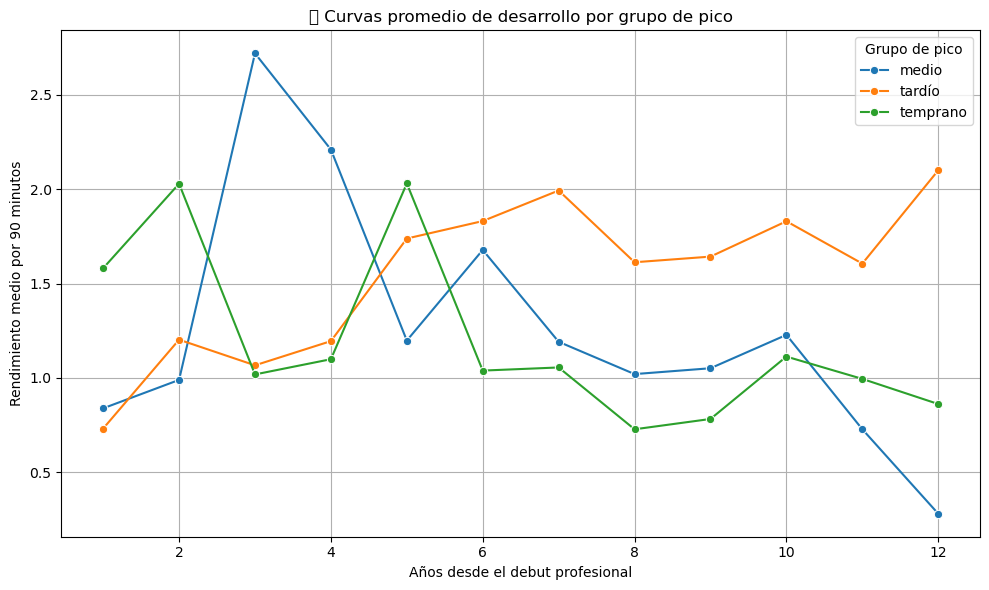

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lineplot of average trajectories by peak group
# Visualizamos las trayectorias promedio por grupo
plt.figure(figsize=(10, 6))
sns.lineplot(data=group_curves, x='year_since_debut', y='rating_per_90', hue='peak_group', marker="o")

plt.title("📈 Curvas promedio de desarrollo por grupo de pico")
plt.xlabel("Años desde el debut profesional")
plt.ylabel("Rendimiento medio por 90 minutos")
plt.grid(True)
plt.legend(title="Grupo de pico")
plt.tight_layout()
plt.show()


#### LGBM + GridSearchCV

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Definir parámetros
param_grid = {
    'num_leaves': [15, 31],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [5, 8]
}

lgbm = LGBMClassifier(objective='multiclass', class_weight='balanced')

grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2427
[LightGBM] [Info] Number of data points in the train set: 431, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [33]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Print general accuracy
# Imprimimos el accuracy general
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))

# Print detailed classification report
# Mostramos precision, recall y f1-score por clase
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
# Mostramos matriz de confusión
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🔍 Accuracy: 0.691358024691358

📊 Classification Report:
              precision    recall  f1-score   support

       medio       0.53      0.56      0.55        32
      tardío       0.76      0.80      0.78       106
    temprano       0.56      0.38      0.45        24

    accuracy                           0.69       162
   macro avg       0.62      0.58      0.59       162
weighted avg       0.68      0.69      0.68       162


🧩 Confusion Matrix:
[[18 14  0]
 [14 85  7]
 [ 2 13  9]]


In [35]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# Cohen's Kappa score (measures agreement)
# Mide cuánto mejor que el azar está el modelo
kappa = cohen_kappa_score(y_test, y_pred)

# Matthews correlation coefficient (robust multiclase metric)
# Mide la calidad general de la clasificación, especialmente útil si hay clases desbalanceadas
mcc = matthews_corrcoef(y_test, y_pred)

print("🧠 Kappa:", kappa)
print("📈 MCC:", mcc)


🧠 Kappa: 0.37209302325581384
📈 MCC: 0.3739543895203363


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


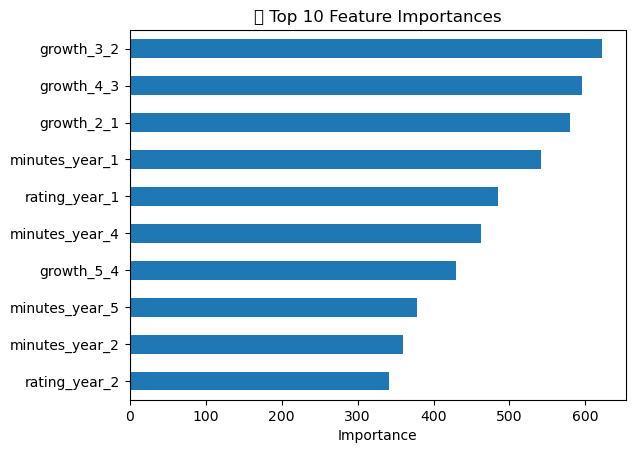

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot feature importances from LightGBM
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("🔍 Top 10 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


#### CatBoost

#### Optuna